In [1]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eshareddyemani","key":"de7ec1eb3090e4a071dd07ad98a8863e"}'}

In [2]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:10<00:00, 147MB/s]
100% 812M/812M [00:10<00:00, 79.0MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

!unzip -qq train.zip



In [5]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 1000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [10]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [13]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_set)//128,
    validation_steps=len(valid_set)//16,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 759ms/step - acc: 0.5210 - loss: 0.6957 - val_acc: 0.5180 - val_loss: 0.6927
Epoch 2/50
2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.5425 - loss: 0.6896

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - acc: 0.5431 - loss: 0.6892 - val_acc: 0.4940 - val_loss: 0.6932
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 613ms/step - acc: 0.5731 - loss: 0.6841 - val_acc: 0.4940 - val_loss: 0.6995
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - acc: 0.5581 - loss: 0.6915 - val_acc: 0.5420 - val_loss: 0.6910
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 601ms/step - acc: 0.5627 - loss: 0.6883 - val_acc: 0.5200 - val_loss: 0.6910
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - acc: 0.5874 - loss: 0.6796 - val_acc: 0.5120 - val_loss: 0.6921
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - acc: 0.5537 - loss: 0.6796 - val_acc: 0.4940 - val_loss: 0.7054
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - acc: 0.5598 - loss: 0.6789 - val_acc: 0.5160 - val_loss: 0.6908
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 603ms/step - acc: 0.5458 - loss: 0.6852 - val_acc: 0.5120 - val_loss: 0.6904
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - acc: 0.5183 - loss: 0.6898 -

Text(0.5, 1.0, 'Training and validation loss')

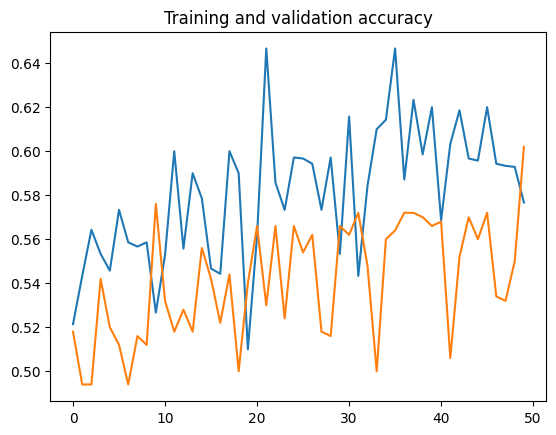

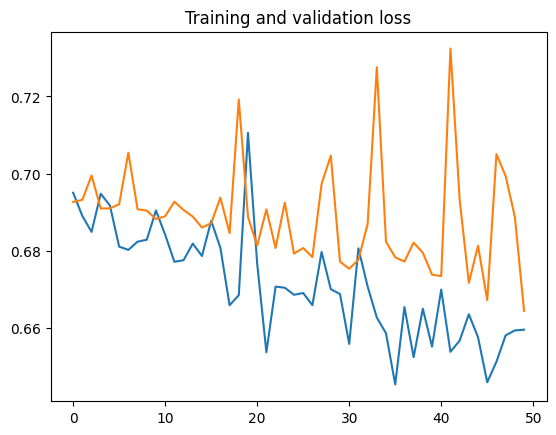

In [14]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_set)//128)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - acc: 0.5900 - loss: 0.6766

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - acc: 0.6008 - loss: 0.6670
Test Loss: 0.660922110080719
Test Accuracy: 0.6100000143051147


In [16]:
# Augmentation settings for training data
train_datagen_augmented = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # rescale should be included in data augmentation for consistency
)

# Apply data augmentation to the subset of 1000 training samples
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)


Found 1000 validated image filenames belonging to 2 classes.


In [18]:

history_augmented = model.fit(
    train_generator_augmented,
    validation_data=valid_generator,
    steps_per_epoch=len(train_set)//128,
    validation_steps=len(valid_set)//16,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - acc: 0.6053 - loss: 0.6623

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 664ms/step - acc: 0.6036 - loss: 0.6625 - val_acc: 0.5900 - val_loss: 0.6653
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - acc: 0.6074 - loss: 0.6487 - val_acc: 0.5120 - val_loss: 0.7256
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 451ms/step - acc: 0.5869 - loss: 0.6581 - val_acc: 0.5780 - val_loss: 0.6705
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - acc: 0.6655 - loss: 0.6265 - val_acc: 0.5320 - val_loss: 0.7073
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 363ms/step - acc: 0.5985 - loss: 0.6572 - val_acc: 0.5240 - val_loss: 0.6940
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - acc: 0.6348 - loss: 0.6326 - val_acc: 0.5820 - val_loss: 0.6726
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - acc: 0.5930 - loss: 0.6492 - val_acc: 0.5700 - val_loss: 0.6772
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - acc: 0.6362 - loss: 0.6323 - val_acc: 0.5580 - val_loss: 0.6843
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 601ms/step - acc: 0.5755 - loss: 0.6718 

Text(0.5, 1.0, 'Training and validation loss')

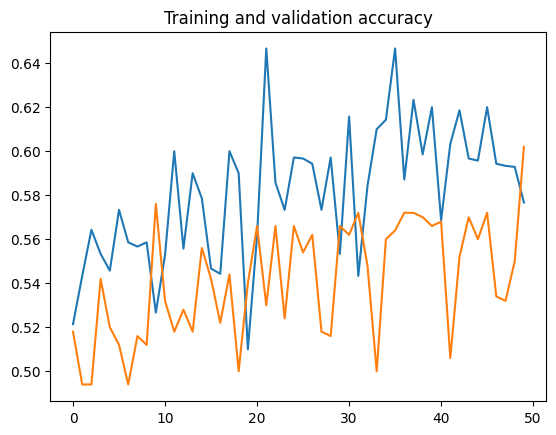

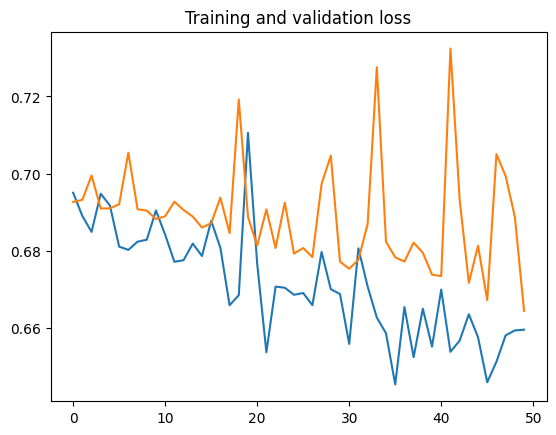

In [19]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [20]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_set)//128)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - acc: 0.5979 - loss: 0.6784
Test Loss: 0.6712977290153503
Test Accuracy: 0.6033333539962769


In [21]:
TOTAL_TRAIN_SIZE = 5000  # Total number of training samples
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [22]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [25]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_set)//128,
    validation_steps=len(valid_set)//16,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 793ms/step - acc: 0.5161 - loss: 0.6948 - val_acc: 0.5260 - val_loss: 0.6906
Epoch 2/50
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - acc: 0.5200 - loss: 0.6884

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - acc: 0.5387 - loss: 0.6910 - val_acc: 0.4980 - val_loss: 0.6900
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 782ms/step - acc: 0.5462 - loss: 0.6878 - val_acc: 0.5200 - val_loss: 0.6853
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - acc: 0.5725 - loss: 0.6785 - val_acc: 0.5720 - val_loss: 0.6793
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 700ms/step - acc: 0.5635 - loss: 0.6794 - val_acc: 0.5380 - val_loss: 0.6906
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - acc: 0.5472 - loss: 0.6836 - val_acc: 0.5920 - val_loss: 0.6721
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 825ms/step - acc: 0.5950 - loss: 0.6704 - val_acc: 0.5120 - val_loss: 0.7080
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - acc: 0.5854 - loss: 0.6612 - val_acc: 0.5740 - val_loss: 0.6624
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 774ms/step - acc: 0.6010 - loss: 0.6661 - val_acc: 0.6080 - val_loss: 0.6638
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - acc: 0.5943 

In [25]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')""

In [27]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_set)//128)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - acc: 0.6383 - loss: 0.6185
Test Loss: 0.6049394011497498
Test Accuracy: 0.6566666960716248


In [28]:
# Augmentation settings for training data
train_datagen_augmented = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # rescale should be included in data augmentation for consistency
)

# Apply data augmentation to the subset of 1000 training samples
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


In [29]:

history_augmented = model.fit(
    train_generator_augmented,
    validation_data=valid_generator,
    steps_per_epoch=len(train_set)//128,
    validation_steps=len(valid_set)//16,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - acc: 0.6975 - loss: 0.5694

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 808ms/step - acc: 0.6976 - loss: 0.5695 - val_acc: 0.6740 - val_loss: 0.5944
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - acc: 0.6996 - loss: 0.5631 - val_acc: 0.7040 - val_loss: 0.5457
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 764ms/step - acc: 0.7090 - loss: 0.5551 - val_acc: 0.6720 - val_loss: 0.5772
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - acc: 0.7046 - loss: 0.5571 - val_acc: 0.7180 - val_loss: 0.5325
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 711ms/step - acc: 0.7067 - loss: 0.5683 - val_acc: 0.7020 - val_loss: 0.5310
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - acc: 0.6896 - loss: 0.5755 - val_acc: 0.6900 - val_loss: 0.5675
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 772ms/step - acc: 0.7111 - loss: 0.5524 - val_acc: 0.7240 - val_loss: 0.5276
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - acc: 0.7194 - loss: 0.5472 - val_acc: 0.6880 - val_loss: 0.5663
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 777ms/step - acc: 0.7026

Text(0.5, 1.0, 'Training and validation loss')

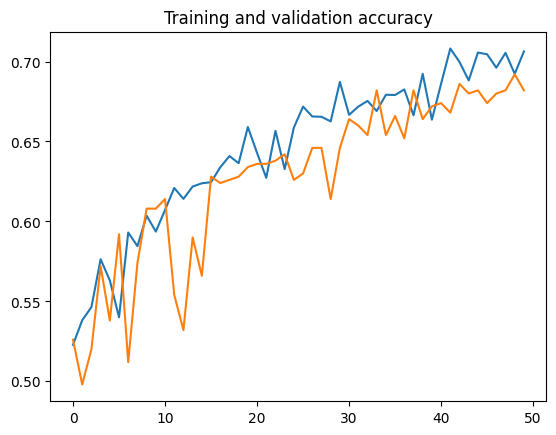

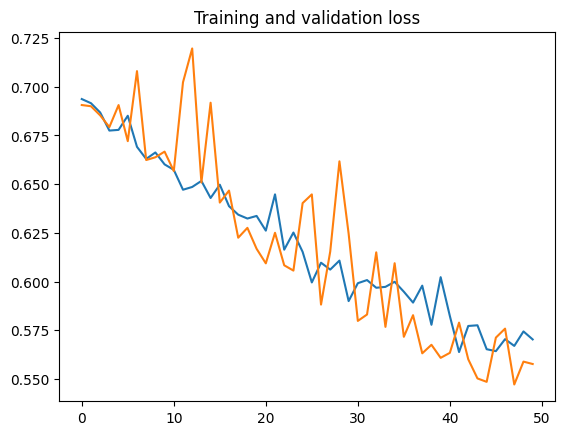

In [32]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [33]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_set)//128)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - acc: 0.7262 - loss: 0.5609
Test Loss: 0.5828629732131958
Test Accuracy: 0.7099999785423279


In [34]:
TOTAL_TRAIN_SIZE = 10000
VALID_SIZE = 2000
TEST_SIZE = 2000

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# Creating dataframe with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# Augmentation settings for training data
train_datagen_augmented = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

# Data generators
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)


Found 10000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [35]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer with dropout rate of 25%
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer with dropout rate of 25%
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer with dropout rate of 25%
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer with dropout rate of 25%
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))   # Dropout layer with dropout rate of 50%
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))   # Dropout layer with dropout rate of 50%
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [39]:

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_set)//128,
    validation_steps=len(valid_set)//16,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50
50/78 ━━━━━━━━━━━━━━━━━━━━ 17s 643ms/step - acc: 0.5070 - loss: 0.6960

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 466ms/step - acc: 0.5091 - loss: 0.6955 - val_acc: 0.5775 - val_loss: 0.6922
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 78s 436ms/step - acc: 0.5353 - loss: 0.6909 - val_acc: 0.5205 - val_loss: 0.6902
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - acc: 0.5320 - loss: 0.6909 - val_acc: 0.5170 - val_loss: 0.6916
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 446ms/step - acc: 0.5490 - loss: 0.6875 - val_acc: 0.5345 - val_loss: 0.6901
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step - acc: 0.5467 - loss: 0.6873 - val_acc: 0.5895 - val_loss: 0.6822
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 440ms/step - acc: 0.5664 - loss: 0.6813 - val_acc: 0.5610 - val_loss: 0.6845
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 448ms/step - acc: 0.5713 - loss: 0.6760 - val_acc: 0.5995 - val_loss: 0.6736
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 436ms/step - acc: 0.5884 - loss: 0.6706 - val_acc: 0.5950 - val_loss: 0.6694
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 441ms/step - acc:

Text(0.5, 1.0, 'Training and validation loss')

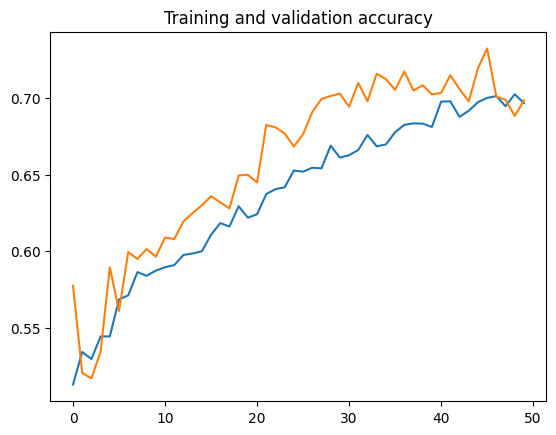

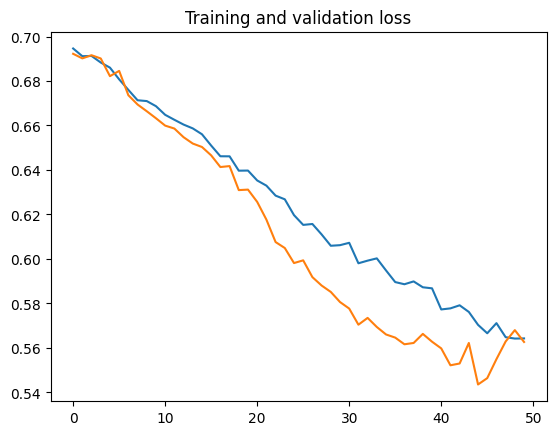

In [40]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [41]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_set)//128)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - acc: 0.6654 - loss: 0.5825
Test Loss: 0.5933846831321716
Test Accuracy: 0.6666666865348816


In [42]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 1000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [46]:
from keras.applications import VGG16
from keras import layers, models
from keras import optimizers

# Load the VGG16 model, without the top (fully connected) layers
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional base
for layer in vgg_conv.layers:
    layer.trainable = False

# Create a new model with the pretrained base
model_vgg16 = models.Sequential()
model_vgg16.add(vgg_conv)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_vgg16.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(learning_rate=1e-4),
                    metrics=['acc'])

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_set)//128,
    validation_steps=len(valid_set)//16,
    epochs=EPOCHS,
    verbose=1
)

# Evaluate on test set
test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_generator, steps=len(test_set)//128)
print("Test Loss VGG16:", test_loss_vgg16)
print("Test Accuracy VGG16:", test_accuracy_vgg16)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - acc: 0.5315 - loss: 0.9195 - val_acc: 0.7800 - val_loss: 0.5079
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - acc: 0.6676 - loss: 0.6160 - val_acc: 0.8120 - val_loss: 0.4773
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 854ms/step - acc: 0.6512 - loss: 0.6393 - val_acc: 0.7120 - val_loss: 0.5190
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - acc: 0.7124 - loss: 0.5828 - val_acc: 0.8380 - val_loss: 0.4141
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 586ms/step - acc: 0.7228 - loss: 0.5402 - val_acc: 0.6820 - val_loss: 0.5457
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - acc: 0.6538 - loss: 0.6278 - val_acc: 0.8480 - val_loss: 0.3799
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 703ms/step - acc: 0.7419 - loss: 0.4883 - val_acc: 0.8260 - val_loss: 0.3772
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - acc: 0.7193 - loss: 0.5513 - val_acc: 0.7220 - val_loss: 0.5357
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 906ms/step - acc: 0.7344 - loss: 0.5172 - val_acc: 0.8080 - val_loss: 0.4012
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - acc: 0.7783 - loss: 0.4830

Text(0.5, 1.0, 'Training and validation loss')

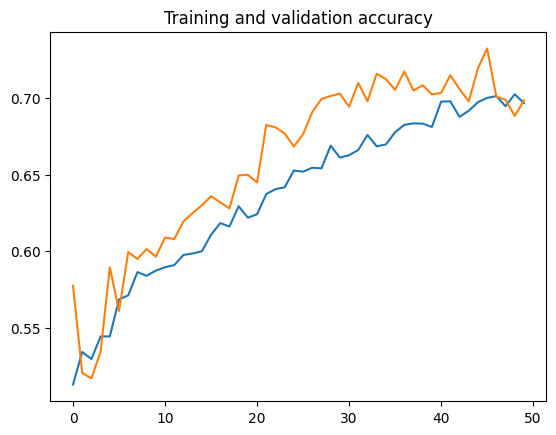

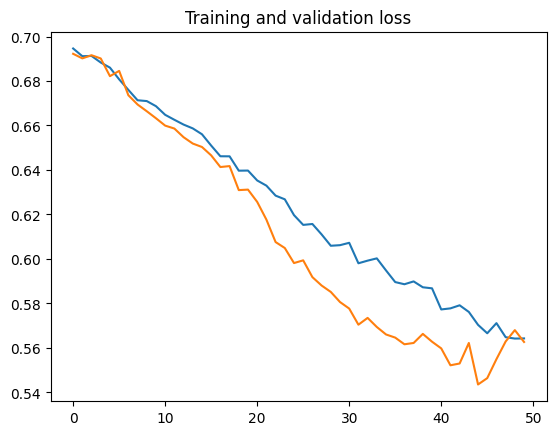

In [47]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history[ 'val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [6]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 5000
VALID_SIZE = 500
TEST_SIZE = 500

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [7]:
from keras.applications import VGG16
from keras import layers, models
from keras import optimizers

# Load the VGG16 model, without the top (fully connected) layers
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional base
for layer in vgg_conv.layers:
    layer.trainable = False

# Create a new model with the pretrained base
model_vgg16 = models.Sequential()
model_vgg16.add(vgg_conv)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_vgg16.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(learning_rate=1e-4),
                    metrics=['acc'])

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_set)//128,
    validation_steps=len(valid_set)//16,
    epochs=EPOCHS,
    verbose=1
)

# Evaluate on test set
test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_generator, steps=len(test_set)//128)
print("Test Loss VGG16:", test_loss_vgg16)
print("Test Accuracy VGG16:", test_accuracy_vgg16)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - acc: 0.6092 - loss: 0.7937

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


39/39 ━━━━━━━━━━━━━━━━━━━━ 65s 963ms/step - acc: 0.6107 - loss: 0.7897 - val_acc: 0.8420 - val_loss: 0.3849
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 0.7627 - loss: 0.4816 - val_acc: 0.8240 - val_loss: 0.4026
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 54s 862ms/step - acc: 0.7732 - loss: 0.4521 - val_acc: 0.8500 - val_loss: 0.3331
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 0.7873 - loss: 0.4427 - val_acc: 0.8580 - val_loss: 0.3172
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 872ms/step - acc: 0.8177 - loss: 0.4048 - val_acc: 0.8540 - val_loss: 0.3250
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - acc: 0.8051 - loss: 0.4333 - val_acc: 0.8540 - val_loss: 0.3252
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 891ms/step - acc: 0.8193 - loss: 0.3749 - val_acc: 0.8660 - val_loss: 0.2909
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - acc: 0.8261 - loss: 0.4065 - val_acc: 0.8800 - val_loss: 0.2884
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 893ms/step - acc: 0.8

Text(0.5, 1.0, 'Training and validation loss')

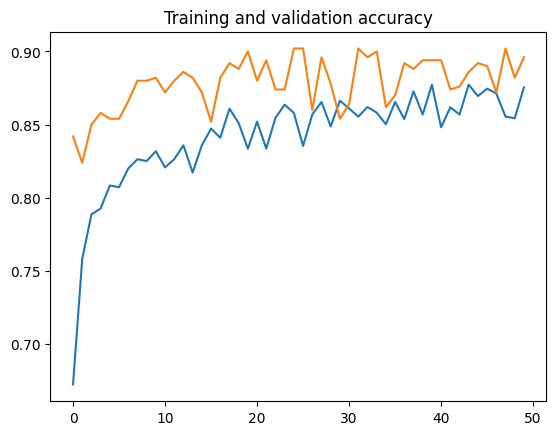

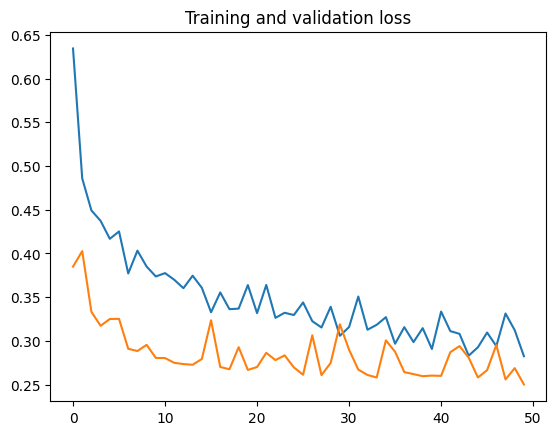

In [10]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history_vgg16.history['acc']
val_acc = history_vgg16.history[ 'val_acc']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [8]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "/content/train"
TEST_DIR = "/content/test1"

TOTAL_TRAIN_SIZE = 10000
VALID_SIZE = 2000
TEST_SIZE = 2000

BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = [filename.split('.')[0] for filename in train_filenames]

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# Shuffle the DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_set = train_df[:TOTAL_TRAIN_SIZE]
remaining_set = train_df[TOTAL_TRAIN_SIZE:]

valid_set = remaining_set[:VALID_SIZE]
test_set = remaining_set[VALID_SIZE:VALID_SIZE+TEST_SIZE]

# augmentation settings, for now just normalizing
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# not doing any data augmentation on validation and test set
valid_test_datagen = ImageDataGenerator(rescale=1./255.)

# creating train, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    valid_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_generator = valid_test_datagen.flow_from_dataframe(
    test_set,
    TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 10000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [11]:
from keras.applications import VGG16
from keras import layers, models
from keras import optimizers

# Load the VGG16 model, without the top (fully connected) layers
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional base
for layer in vgg_conv.layers:
    layer.trainable = False

# Create a new model with the pretrained base
model_vgg16 = models.Sequential()
model_vgg16.add(vgg_conv)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(512, activation='relu'))
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_vgg16.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(learning_rate=1e-4),
                    metrics=['acc'])

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_set)//128,
    validation_steps=len(valid_set)//16,
    epochs=EPOCHS,
    verbose=1
)

# Evaluate on test set
test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_generator, steps=len(test_set)//128)
print("Test Loss VGG16:", test_loss_vgg16)
print("Test Accuracy VGG16:", test_accuracy_vgg16)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 84s 912ms/step - acc: 0.6424 - loss: 0.7121 - val_acc: 0.8745 - val_loss: 0.3056
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - acc: 0.7944 - loss: 0.4420 - val_acc: 0.8580 - val_loss: 0.3282
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 77s 893ms/step - acc: 0.7868 - loss: 0.4502 - val_acc: 0.8555 - val_loss: 0.3257
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - acc: 0.8128 - loss: 0.4028 - val_acc: 0.8380 - val_loss: 0.3717
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 75s 906ms/step - acc: 0.8208 - loss: 0.3919 - val_acc: 0.8895 - val_loss: 0.2609
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 244ms/step - acc: 0.8067 - loss: 0.3998 - val_acc: 0.8730 - val_loss: 0.2933
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 75s 894ms/step - acc: 0.8315 - loss: 0.3711 - val_acc: 0.8845 - val_loss: 0.2669
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 241ms/step - acc: 0.8302 - loss: 0.3570 - val_acc: 0.8940 - val_loss: 0.2490
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 77s 894ms/step - acc: 0.8504 - loss: 0.3456 - val_acc: 0.9000 - val_loss: 0.2405
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - acc

Text(0.5, 1.0, 'Training and validation loss')

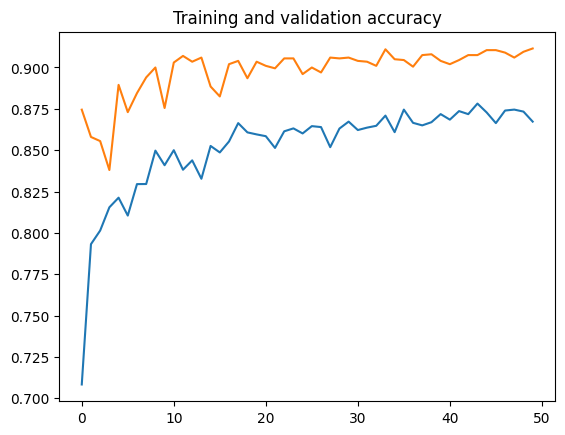

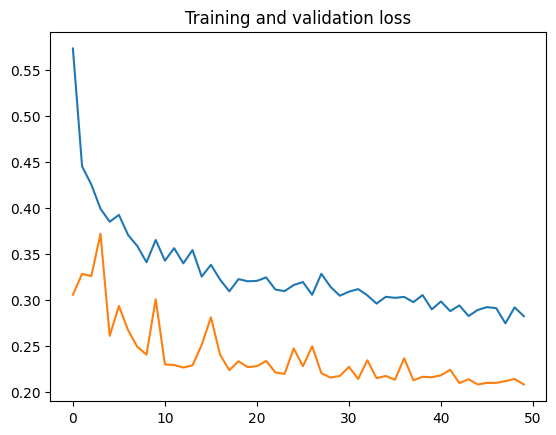

In [12]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history_vgg16.history['acc']
val_acc = history_vgg16.history[ 'val_acc']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')